In [1]:
# Google colab setup.
import subprocess
import sys

def setup_google_colab_execution():
    subprocess.run(["git", "clone", "https://github.com/bookingcom/uplift-modeling-for-marketing-personalization-tutorial"]) 
    subprocess.run(["pip", "install", "-r", "uplift-modeling-for-marketing-personalization-tutorial/tutorial/requirements-colab.txt"]) 
    subprocess.run(["cp", "uplift-modeling-for-marketing-personalization-tutorial/tutorial/notebooks/utils.py", "./"])

running_on_google_colab = 'google.colab' in sys.modules

if running_on_google_colab:
    setup_google_colab_execution()

# Explainability and Trust

Building trust in your models is crucial for adoption by business stakeholders. One way to convey trust is to provide insight about your models' outcomes.

Options to provides insights for causal models are:
- Feature vs Outcome distributions based on targeted population
- SHAP using a surrogate model

## 1. Feature Distributions per Share of Targeted Population
Visualizing feature distributions across different segments of the targeted population helps identify biases in specific groups.

In [2]:
from causalml.dataset import synthetic_data
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
from utils import booking_colors
from cycler import cycler

mpl.rcdefaults()
plt.style.use('default')
sns.set_style("whitegrid")
plt.rc('axes', prop_cycle=cycler(color=list(booking_colors.values())))

np.random.seed(42)

Let's start by training an S-Leaner

In [3]:
# Generate synthetic data
y, X, treatment, tau, b, e = synthetic_data(mode=2, n=5000, p=5, sigma=1.0)

# Convert data to a pandas DataFrame
df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
df['treatment'] = treatment
df['outcome'] = y
df['tau'] = tau  # True CATE

# Show sample data
df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,treatment,outcome,tau
0,0.496714,-0.138264,0.647689,1.523030,-0.234153,1,2.787963,1.123117
1,-0.234137,1.579213,0.767435,-0.469474,0.542560,1,0.992414,1.532499
2,-0.463418,-0.465730,0.241962,-1.913280,-1.724918,0,-0.588904,0.023736
3,-0.562288,-1.012831,0.314247,-0.908024,-1.412304,1,1.111354,-0.252461
4,1.465649,-0.225776,0.067528,-1.424748,-0.544383,0,2.090639,2.052266


In [4]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
# Split data into training and testing sets
X = df.drop(columns=['outcome', 'tau'])  # Keep treatment as a feature
y = df['outcome']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train S-Learner model
s_learner = LGBMRegressor()
s_learner.fit(X_train, y_train)

# Predict outcomes for treated and untreated scenarios
X_test_treated = X_test.copy()
X_test_treated['treatment'] = 1
X_test_untreated = X_test.copy()
X_test_untreated['treatment'] = 0

# Estimate the treatment effect using the S-Learner
treatment_effect_s_learner = s_learner.predict(X_test_treated) - s_learner.predict(X_test_untreated)
X_test["score"] = treatment_effect_s_learner

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 6
[LightGBM] [Info] Start training from score 1.419537


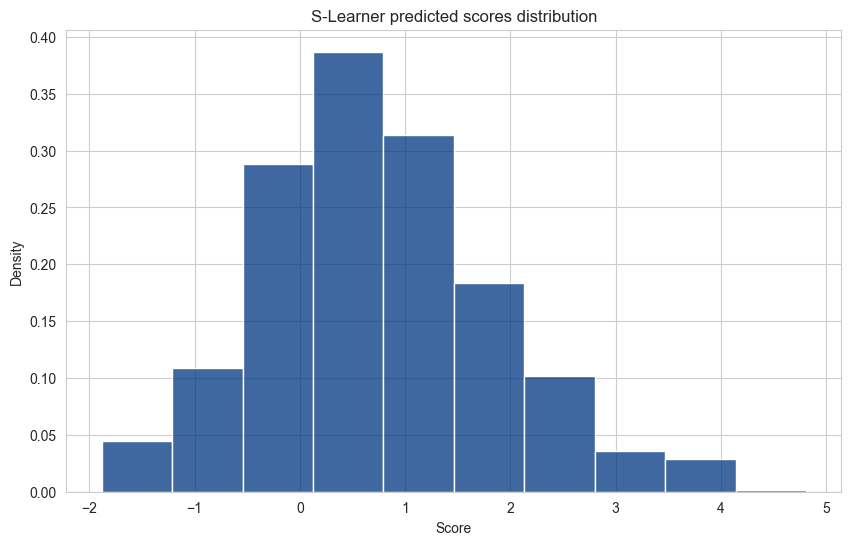

In [5]:
# plot the distribution of the model scores - the s-learner treatment effect
plt.figure(figsize=(10, 6))
sns.histplot(X_test, x='score', kde=False, stat='density', common_norm=False, bins=10)

plt.title('S-Learner predicted scores distribution')
plt.xlabel('Score')
plt.ylabel('Density')
plt.show()

Each bucket of the distribution represent a subset of the targeted population. 

Let's now observe how the distribution of a feature vary as we offer the treatment to a bigger percentage of the population

In [6]:
features_df = X_test.copy()
features = ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4']

# Let's first create a bucketized version of the numerical input features 
for feature in features:
    features_df[feature + '_binned'] = pd.cut(features_df[feature], bins=4, labels=False)

In [7]:
# pick a sample feature for the analysis
example_feature = 'feature_0_binned'

from utils import create_feature_cumulative_buckets
number_of_buckets = 10
# The create_feature_cumulative_buckets function will:
# - Split the score into n buckets
# - Compute, starting from the highest bucket (the population with the highest treatment effect) the cumulative number of occurrences of each feature value
feature_df = create_feature_cumulative_buckets(features_df, number_of_buckets, example_feature)

feature_df.sort_values(by=["score_bucket", "feature_0_binned"], ascending=[True,True]).head(10)

,feature_0_binned,score_bucket,count,cum_count
0,0,0,13.0,13.0
1,1,0,17.0,17.0
2,2,0,0.0,0.0
3,3,0,0.0,0.0
4,0,1,4.0,17.0
5,1,1,69.0,86.0
6,2,1,0.0,0.0
7,3,1,0.0,0.0
8,0,2,1.0,18.0
9,1,2,182.0,268.0


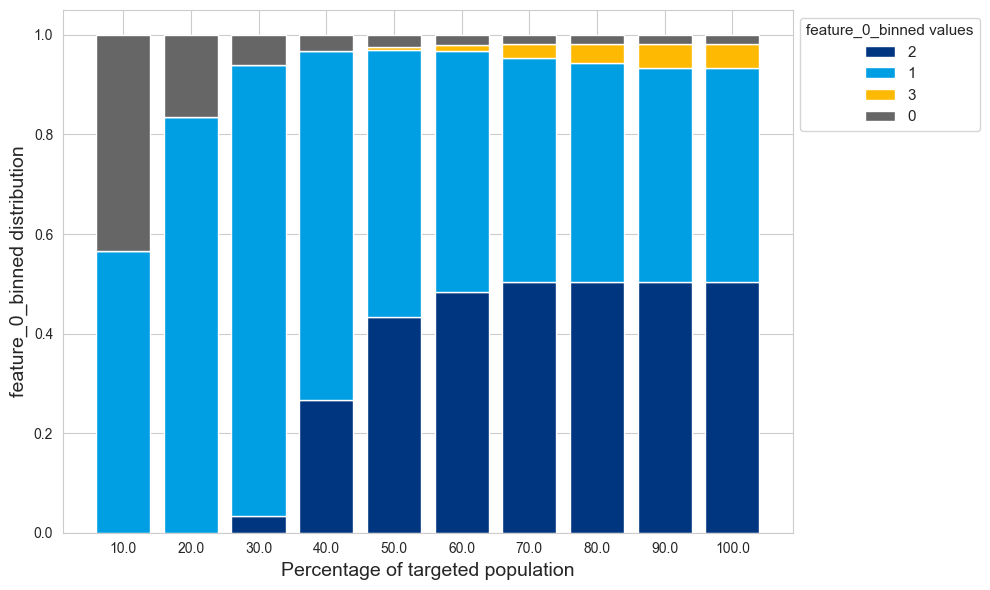

In [8]:
bar_data = feature_df.groupby(["score_bucket", example_feature])["cum_count"].sum().unstack().fillna(0)
bar_data = bar_data.div(bar_data.sum(axis=1), axis=0)
bottom_values = pd.Series([0] * len(bar_data), index=bar_data.index)
allocated_traffic = ((1+bar_data.index)/number_of_buckets)*100

plt.figure(figsize=(10, 6))
for col in bar_data[bar_data.iloc[number_of_buckets-1].sort_values(ascending=False).index].columns:
    plt.bar(bar_data.index, bar_data[col], bottom=bottom_values, label=col)
    bottom_values += bar_data[col]
plt.xticks(ticks=np.arange(len(bar_data.index)), labels=allocated_traffic)
plt.xlabel("Percentage of targeted population", fontsize=14)
plt.ylabel(f"{example_feature} distribution", fontsize=14)
plt.legend(title=f"{example_feature} values", title_fontsize="11", fontsize="11", bbox_to_anchor=(1.00, 1), loc='upper left')

plt.tight_layout()
plt.show()

## 2. SHAP: SHapley Additive exPlanations

**[SHAP](https://shap.readthedocs.io/en/latest/index.html)** is a method derived from cooperative game theory. It is used to explain the output of machine learning models by assigning each feature an importance value for a particular prediction (Papers: [SHAP](https://papers.nips.cc/paper_files/paper/2017/hash/8a20a8621978632d76c43dfd28b67767-Abstract.html), [SHAP Tree explainer](https://www.nature.com/articles/s42256-019-0138-9.epdf?shared_access_token=RCYPTVkiECUmc0CccSMgXtRgN0jAjWel9jnR3ZoTv0O81kV8DqPb2VXSseRmof0Pl8YSOZy4FHz5vMc3xsxcX6uT10EzEoWo7B-nZQAHJJvBYhQJTT1LnJmpsa48nlgUWrMkThFrEIvZstjQ7Xdc5g%3D%3D)). 

### Background
Shapley values' are originally used in cooperative theory to fairly distribute the "payout" among players depending on their contribution to the overall game. In the context of machine learning, the "game" is the prediction task, and the "players" are the features in the dataset. The SHAP framework calculates the contribution of each feature to a prediction by considering all possible combinations of features and evaluating their marginal contribution.

### How SHAP Works
SHAP values provide a way to explain individual predictions by computing the contribution of each feature towards the prediction. This is done by comparing what the model predicts with and without the feature of interest, across all possible combinations of features. The result is a set of additive importance values that sum to the model's output for a particular instance.

- **Local Interpretability**: SHAP values for a single instance reveal why a specific prediction was made, giving insights into the model's behavior for that particular case.
- **Global Interpretability**: By aggregating SHAP values across many instances, one can understand the overall impact of each feature on the model's predictions.

### SHAP in Uplift Models

- SHAP values remain a powerful tool for explaining predictions in uplift models. They provide insights into feature importance and how each feature contributes to the predicted uplift.
- SHAP works well with higher order models (T-learners, S-learners, X-learners, ...), especially when using a surrogate model to approximate the treatment effect.

#### Higher-Order Models: SHAP Surrogates
- Higher-order models can be explained using a [global surrogate model](https://christophm.github.io/interpretable-ml-book/global.html#global), allowing you to simplify the model’s explanation while retaining interpretability.

#### Example: SHAP with a Surrogate Model for an S-Learner
SHAP values are typically used to explain predictions of a single model, not the difference between two model outputs, as in the case of S-Learner uplift predictions.

This is where a **SHAP Surrogate Model** comes into play: A surrogate model is a simpler or more interpretable model that approximates the behavior of a more complex model. For S-Learner explanations, we can use a surrogate model trained specifically to predict the treatment effect directly, rather than the outcome.

In [9]:
# The S-learner is trained on the outcome
pd.concat([X_train, y_train], axis=1).head()

,feature_0,feature_1,feature_2,feature_3,feature_4,treatment,outcome
4227,0.057054,-0.081551,-1.297212,0.160135,-0.583626,0,1.240913
4676,-0.761419,-0.478505,0.810051,-1.501827,1.105807,0,-1.086773
800,-0.863494,-0.031203,0.018017,0.472630,-1.366858,0,-0.858750
3671,1.838755,1.605690,-0.875324,0.072802,1.710809,1,6.664757
4193,0.557739,-0.107983,0.140180,0.897722,0.929312,0,0.750874


In [10]:
# The surrogate model will be trained on the treatment effect
X_test_surrogate = X_test.drop(columns=["treatment", "score"]).reset_index(drop=True)
treatment_effect_s_learner = pd.Series(treatment_effect_s_learner, 
                                       name="treatment_effect_s_learner")
pd.concat([X_test_surrogate, treatment_effect_s_learner], axis=1).head()

,feature_0,feature_1,feature_2,feature_3,feature_4,treatment_effect_s_learner
0,-2.241916,0.205456,-0.775607,-0.800335,-0.498987,-1.528042
1,-0.719472,-0.625107,0.943159,-0.008871,1.133688,-0.119800
2,1.126238,-0.240398,0.767844,-0.194585,0.033871,1.477655
3,0.783359,-1.470490,-1.262770,-0.775875,0.078964,1.314942
4,-1.173880,-0.197938,2.067906,-1.831682,-1.051310,0.045547


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 5
[LightGBM] [Info] Start training from score 0.752923


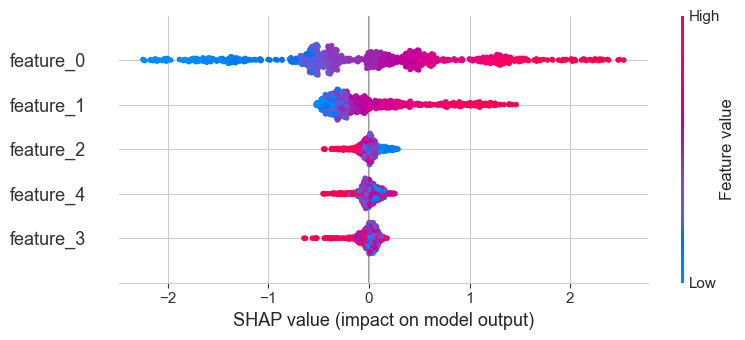

In [11]:
import shap
from lightgbm import LGBMRegressor
# Train a surrogate model to predict the treatment effect using regression
surrogate_model = LGBMRegressor()  # Changed to a regression model
surrogate_model.fit(X_test_surrogate, treatment_effect_s_learner)

# Use SHAP to explain the surrogate model
explainer = shap.TreeExplainer(surrogate_model)
shap_values = explainer.shap_values(X_test_surrogate)

# Plot SHAP summary plot for feature importance
shap.summary_plot(shap_values, X_test_surrogate, feature_names=X_test_surrogate.columns)

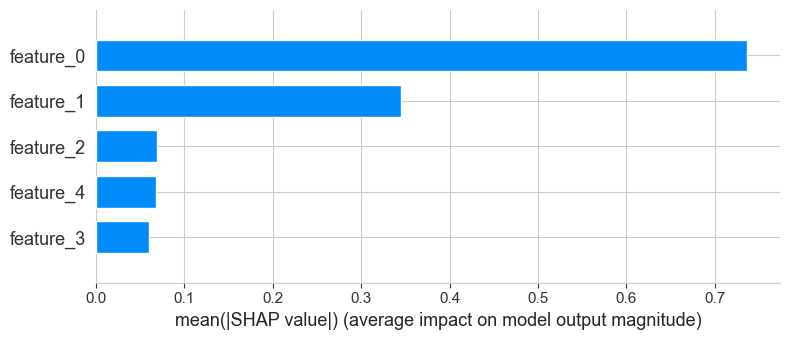

In [12]:
shap.summary_plot(shap_values, X_test_surrogate, feature_names=X_test_surrogate.columns, plot_type="bar")